# Walidacja Mateusz Andryszak, Jakub Rymarski

Swoje uwagi i własne pomysły będziemy komentować jako Wal:
# Credit score classification - grupa nr 5: Wojtek Grabias, Wiktor Wierzchowski

## importy, split i funkcje

In [1]:
%%capture --no-stderr

import pandas as pd
from sklearn import preprocessing
from sklearn.preprocessing import MultiLabelBinarizer
from datetime import datetime
from pandas.api.types import is_numeric_dtype
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
np.random.seed(29)

In [2]:
df_original = pd.read_csv('train.csv', low_memory=False)

df, X_test, df_target, y_test = train_test_split(
    df_original[df_original.columns.values[:-1]], # X
    df_original[df_original.columns.values[-1]], # y
    test_size=0.30, random_state=42)

Wal: Jako walidacja będziemy działać na ramce walidacyjnej.

In [3]:
df=X_test
df_target=y_test

In [4]:
df.head()

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Num_Credit_Inquiries,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance
75721,0x1d1af,CUS_0x3539,February,an Arakalid,30,995-31-4669,Manager,43391.96,3688.996667,1,...,0.0,Good,1468.28,29.112468,23 Years and 8 Months,No,0.000000,53.969385063055675,High_spent_Large_value_payments,554.9302816036111
80184,0x1ebd6,CUS_0x8716,January,Matthewz,18,185-99-8068,Scientist,14351.21,NaN,8,...,9.0,Bad,4766.87,39.849732,NaN,Yes,61.098718,118.08021357217683,Low_spent_Small_value_payments,238.3144849566528
19864,0x8a66,CUS_0x21dc,January,Tom Miless,41,241-53-8475,Developer,130125.04,10871.753333,5,...,645.0,Good,1195.05,21.542892,15 Years and 11 Months,No,204.285650,1255.8993022448951,Low_spent_Small_value_payments,NaN
76699,0x1d769,CUS_0x32d3,April,Lisaa,35,204-78-6176,Manager,20107.21,1631.600833,6,...,11.0,Standard,2544.6,32.423759,19 Years and 4 Months,Yes,27.106395,66.81977464950728,Low_spent_Small_value_payments,359.23391378882377
92991,0x236dd,CUS_0xadad,August,Masond,27,027-11-6852,Doctor,92186.19,7487.182500,1,...,4.0,Good,809.01,39.543131,20 Years and 9 Months,No,185.797654,115.52003931707223,High_spent_Medium_value_payments,697.4005568630175


## Dalsza prezentacja tylko dla ramki treningowej, proces działania dla ramki walidacyjnej w pełni analogiczny.

Wal: Zgadzamy się warto zamienić w tym wypadku typy obiekt na numeric. W przypadku kolumny Credit_History_Age rzeczywiście najważniejsza jest liczba lat, liczba miesięcy wydaje się być nieistotna.

In [5]:
def History_Age_2_months(df):
    df['Credit_History_Age'] = df['Credit_History_Age'].str.replace(' Months', '')
    return df['Credit_History_Age'].str.replace('\D+', '* 12 +')
def Object_to_Numeric(df, s):
    return pd.to_numeric(df[s].str.replace('_', ''))

## podstawowe zaznajomienie z ramką

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 75721 to 34122
Data columns (total 27 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ID                        30000 non-null  object 
 1   Customer_ID               30000 non-null  object 
 2   Month                     30000 non-null  object 
 3   Name                      26999 non-null  object 
 4   Age                       30000 non-null  object 
 5   SSN                       30000 non-null  object 
 6   Occupation                30000 non-null  object 
 7   Annual_Income             30000 non-null  object 
 8   Monthly_Inhand_Salary     25488 non-null  float64
 9   Num_Bank_Accounts         30000 non-null  int64  
 10  Num_Credit_Card           30000 non-null  int64  
 11  Interest_Rate             30000 non-null  int64  
 12  Num_of_Loan               30000 non-null  object 
 13  Type_of_Loan              26619 non-null  object 
 14  De

In [7]:
df.columns

Index(['ID', 'Customer_ID', 'Month', 'Name', 'Age', 'SSN', 'Occupation',
       'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts',
       'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan', 'Type_of_Loan',
       'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit',
       'Num_Credit_Inquiries', 'Credit_Mix', 'Outstanding_Debt',
       'Credit_Utilization_Ratio', 'Credit_History_Age',
       'Payment_of_Min_Amount', 'Total_EMI_per_month',
       'Amount_invested_monthly', 'Payment_Behaviour', 'Monthly_Balance'],
      dtype='object')

Wal: Dobry ruch, trzeba sprawdzić, że ID jest unikalne, aby uniknąć później ewentualnych pomyłek.

In [8]:
df['ID'].drop_duplicates().shape[0]
# każdy wiersz ma swoje id więc wszystkie wpisy w tabeli są unikalne
# df = df.drop(columns = ['ID', 'Name', 'SSN'])

30000

## zamiana typów kolumn na numeryczne

Wal: Ważny krok, w początkowej ramce danych niektóre kolumny, które przechowują wartości liczbowe są typu object. Trzeba zamienić je na typ numeric.

In [9]:
df['Outstanding_Debt'] = Object_to_Numeric(df, 'Outstanding_Debt')
df['Amount_invested_monthly'] = Object_to_Numeric(df, 'Amount_invested_monthly')
df['Changed_Credit_Limit'] = Object_to_Numeric(df, 'Changed_Credit_Limit')
df['Monthly_Balance'] = df['Monthly_Balance'].str.replace('_', '')
df = df.astype({'Monthly_Balance': 'float'})

Wal: Też dobre posunięcie.

In [10]:
df['Credit_History_Age'] = History_Age_2_months(df)
df['Credit_History_Age'].loc[df.Credit_History_Age.isnull()] = df['Credit_History_Age'].loc[df.Credit_History_Age.isnull()].apply(
        lambda x: '-1') #Brak danych jest teraz -1
df['Credit_History_Age'] = df['Credit_History_Age'].apply(eval)

<ipython-input-5-1777a396eb58>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  return df['Credit_History_Age'].str.replace('\D+', '* 12 +')
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Wal: Rzeczywiście dane z kolumn Payment_of_Min_Amount i Payment_Behavior powinniśmy przekrztałcić na zmienne binarne.

In [11]:
df['Payment_of_Min_Amount'] = df['Payment_of_Min_Amount'].replace('Yes', 1)
df['Payment_of_Min_Amount'] = df['Payment_of_Min_Amount'].replace('No', 0)
df['Payment_of_Min_Amount'] = df['Payment_of_Min_Amount'].replace('NM', 2)
df['Payment_Behaviour'] = np.where(df['Payment_Behaviour']== '!@9#%8', np.nan, df['Payment_Behaviour'])
df['spent'] = np.where('Low' == df['Payment_Behaviour'].str[0:3], 0,1)
df['payment_value'] = df['Payment_Behaviour'].str.extract(r'^(?:[^_]+_){2}([^_ ]+)')

Wal: Wartości transakcji mogą okazać się bardzo ważne w ocenie wiarygodności.

In [12]:
df['payment_value'] = df['payment_value'].replace('Small', 0)
df['payment_value'] = df['payment_value'].replace('Medium', 1)
df['payment_value'] = df['payment_value'].replace('Large', 2)

Wal: Jeden krok niepotrzebny, payment_value nie przyjmuje wartości 3.

In [13]:
df['payment_value'] = np.where(df['payment_value'] == 3, np.nan, df['payment_value'])
df = df.drop('Payment_Behaviour', axis=1)

Wal: Ok, rodzaje pożyczek mogą odegrać ważną rolę w modelu.

In [14]:
df['Type_of_Loan'] = df['Type_of_Loan'].str.replace('and ', '')
df.Type_of_Loan = df.Type_of_Loan.str.split(', ')
df['Type_of_Loan'].loc[df.Type_of_Loan.isnull()] = df['Type_of_Loan'].loc[df.Type_of_Loan.isnull()].apply(lambda x: [])
mlb = MultiLabelBinarizer(sparse_output=True)
df = df.join(
    pd.DataFrame.sparse.from_spmatrix(
        mlb.fit_transform(df.pop('Type_of_Loan')),
        index=df.index,
        columns=mlb.classes_))

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Wal: Uważamy, że warto wykonać takie przekształcenia.

In [15]:
#2 Month na numeric
df['Month'] = df['Month'].apply(lambda mname: datetime.strptime(mname, '%B').month)

#4 Age na numeric
df['Age'] = df['Age'].convert_dtypes().apply(lambda x: x.replace("_", "")).astype(int)

#7 Annual_Income na numeric
df['Annual_Income'] = df['Annual_Income'].convert_dtypes().apply(lambda x: x.replace("_", "")).astype(float)

#12 Num_of_Loan na numeric
df['Num_of_Loan'] = df['Num_of_Loan'].convert_dtypes().apply(lambda x: x.replace("_", "")).astype(int)

#15 Num_of_Delayed_Payment na numeric
df['Num_of_Delayed_Payment'] = df['Num_of_Delayed_Payment'].convert_dtypes()
df['Num_of_Delayed_Payment'] = df['Num_of_Delayed_Payment'].str.replace('_', '')
df['Num_of_Delayed_Payment'] = pd.to_numeric(df['Num_of_Delayed_Payment'])

In [16]:
df
df.iloc[:, 1:20]

,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio
75721,CUS_0x3539,2,an Arakalid,30,995-31-4669,Manager,43391.96,3688.996667,1,5,10,0,9,6.0,10.72,0.0,Good,1468.28,29.112468
80184,CUS_0x8716,1,Matthewz,18,185-99-8068,Scientist,14351.21,NaN,8,7,18,6,18,17.0,21.91,9.0,Bad,4766.87,39.849732
19864,CUS_0x21dc,1,Tom Miless,41,241-53-8475,Developer,130125.04,10871.753333,5,2,11,2,3,0.0,3.82,645.0,Good,1195.05,21.542892
76699,CUS_0x32d3,4,Lisaa,35,204-78-6176,Manager,20107.21,1631.600833,6,6,32,2,15,13.0,10.40,11.0,Standard,2544.60,32.423759
92991,CUS_0xadad,8,Masond,27,027-11-6852,Doctor,92186.19,7487.182500,1,2,12,4,1,0.0,9.74,4.0,Good,809.01,39.543131
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42648,CUS_0x5a48,1,Pinskerp,52,549-86-5251,Scientist,51410.98,4012.248333,4,7,16,0,8,12.0,1.49,4.0,Standard,743.41,24.916809
86306,CUS_0x4d66,3,alazs Koranyif,44,178-31-0860,Developer,27292.50,2254.375000,5,6,8,4,28,15.0,18.56,4.0,Standard,1434.18,27.798135
45466,CUS_0x1370,3,Rothackerb,31,710-06-0138,Writer,10216.36,679.363333,10,8,22,5,21,23.0,NaN,6.0,Bad,3703.66,28.302862
63724,CUS_0xb13c,5,Jennifert,32,528-06-6283,_______,14613.65,1334.804167,8,8,22,6,20,16.0,4.63,9.0,Bad,2882.07,22.447620


## One-hot

Wal: Credit Mix niesie informację o "doborze portfela" (o róźnorodności zaciągniętych pożyczek), być może kolumna ta powiela informację z kolumny Type_of_Loan. Dodatkowo nie zgadzamy się z takim sposobem zrobienia One-hot-encodingu. Trudno ocenić zależność pomiędzy 'Good, 'Standard' i 'Bad'. Dlaczego 'Good' ma wartość 2, a 'Standard' 1. Może lepsze byłyby wartości 10 i 3. Dodatkowo znak "-" jest zastąpiony wartością 3, co już całkiem zaburza sens uporządkowania danych kategorii jako 0, 1, 2, 3. My proponujemy inny rodzaj One-hot encoding

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 75721 to 34122
Data columns (total 36 columns):
 #   Column                    Non-Null Count  Dtype           
---  ------                    --------------  -----           
 0   ID                        30000 non-null  object          
 1   Customer_ID               30000 non-null  object          
 2   Month                     30000 non-null  int64           
 3   Name                      26999 non-null  object          
 4   Age                       30000 non-null  int32           
 5   SSN                       30000 non-null  object          
 6   Occupation                30000 non-null  object          
 7   Annual_Income             30000 non-null  float64         
 8   Monthly_Inhand_Salary     25488 non-null  float64         
 9   Num_Bank_Accounts         30000 non-null  int64           
 10  Num_Credit_Card           30000 non-null  int64           
 11  Interest_Rate             30000 non-null  int64   

In [18]:
# # My tego nie robimy Credit_Mix na numeric
# df['Credit_Mix'] = df['Credit_Mix'].replace('_', 3)
# df['Credit_Mix'] = df['Credit_Mix'].replace('Good', 2)
# df['Credit_Mix'] = df['Credit_Mix'].replace('Standard', 1)
# df['Credit_Mix'] = df['Credit_Mix'].replace('Bad', 0)

# # Credit_Score na numeric
# df_target = df_target.replace('Good', 2)
# df_target = df_target.replace('Standard', 1)
# df_target = df_target.replace('Poor', 0)

In [19]:
# Wal dodła
one_hot=pd.get_dummies(df['Credit_Mix'])
df=pd.concat([df, one_hot],axis=1)
df.drop(['_', 'Credit_Mix'], axis=1, inplace=True)

# Credit_Score na numeric
df_target = df_target.replace('Good', 2)
df_target = df_target.replace('Standard', 1)
df_target = df_target.replace('Poor', 0)


In [20]:
df.iloc[:, 10:40]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 75721 to 34122
Data columns (total 38 columns):
 #   Column                    Non-Null Count  Dtype           
---  ------                    --------------  -----           
 0   ID                        30000 non-null  object          
 1   Customer_ID               30000 non-null  object          
 2   Month                     30000 non-null  int64           
 3   Name                      26999 non-null  object          
 4   Age                       30000 non-null  int32           
 5   SSN                       30000 non-null  object          
 6   Occupation                30000 non-null  object          
 7   Annual_Income             30000 non-null  float64         
 8   Monthly_Inhand_Salary     25488 non-null  float64         
 9   Num_Bank_Accounts         30000 non-null  int64           
 10  Num_Credit_Card           30000 non-null  int64           
 11  Interest_Rate             30000 non-null  int64   

Wal: Zgadzamy się. Zastanawialiśmy się czy SSN, czyli numer ubezpieczenia społeczengo w USA, niesie jakąś istotną inforamcję o zamożności ubezpieczonego, ale po dokonaniu internetowego researchu dowiedieliśmy się, że jest to tylko numer identyfikacyjny. Można więc go też usunąć. 

In [21]:
df.drop(columns=['ID','Customer_ID','Name','SSN'], inplace=True)

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 75721 to 34122
Data columns (total 34 columns):
 #   Column                    Non-Null Count  Dtype           
---  ------                    --------------  -----           
 0   Month                     30000 non-null  int64           
 1   Age                       30000 non-null  int32           
 2   Occupation                30000 non-null  object          
 3   Annual_Income             30000 non-null  float64         
 4   Monthly_Inhand_Salary     25488 non-null  float64         
 5   Num_Bank_Accounts         30000 non-null  int64           
 6   Num_Credit_Card           30000 non-null  int64           
 7   Interest_Rate             30000 non-null  int64           
 8   Num_of_Loan               30000 non-null  int32           
 9   Delay_from_due_date       30000 non-null  int64           
 10  Num_of_Delayed_Payment    27925 non-null  float64         
 11  Changed_Credit_Limit      29399 non-null  float64 

Wal: Chcieliśmy sprawdzić, czy zawód może wpływać na predykcyjność. Często zawód lekarza, czy prawnika kojarzy się ze stabilnością finansową w to w długim okresie. Po sprawdzeniu okazało się, że nie wydaje się to być istotne.

In [23]:
# one_hot_occup = pd.get_dummies(df['Occupation'])
# df = pd.concat([df, one_hot_occup], axis=1)
# df = df.drop(columns=['Occupation'])
# df

## Usuwanie błędnych wartości

Wal: Zgoda.Są tylko dwie ujemne wartości Monthly_Balance, co wydaje się być wartością błędną. Jednak nie usuwamy ich, tylko zamieniamy na nan Wysoka wartość df.Amount_invested_monthly=10000 również wydaje się być błędna.

In [24]:
# Wal dodała dla sprawdzenia
df.Monthly_Balance.nsmallest(10)
df[df.Amount_invested_monthly==10000]
df[df["Amount_invested_monthly"]==10000].count()
#df[df['Changed_Credit_Limit']<0]['Changed_Credit_Limit']

Month                       1323
Age                         1323
Occupation                  1323
Annual_Income               1323
Monthly_Inhand_Salary       1137
Num_Bank_Accounts           1323
Num_Credit_Card             1323
Interest_Rate               1323
Num_of_Loan                 1323
Delay_from_due_date         1323
Num_of_Delayed_Payment      1228
Changed_Credit_Limit        1295
Num_Credit_Inquiries        1306
Outstanding_Debt            1323
Credit_Utilization_Ratio    1323
Credit_History_Age          1323
Payment_of_Min_Amount       1323
Total_EMI_per_month         1323
Amount_invested_monthly     1323
Monthly_Balance             1306
spent                       1323
payment_value               1227
Auto Loan                   1323
Credit-Builder Loan         1323
Debt Consolidation Loan     1323
Home Equity Loan            1323
Mortgage Loan               1323
Not Specified               1323
Payday Loan                 1323
Personal Loan               1323
Student Lo

In [25]:
#df = df[df.Monthly_Balance != min(df.Monthly_Balance)]
df.Monthly_Balance = np.where(df.Monthly_Balance <0, np.nan, df.Monthly_Balance)
df.Credit_History_Age = np.where(df.Credit_History_Age == -1, np.nan, df.Credit_History_Age)
df.Amount_invested_monthly = np.where(df.Amount_invested_monthly == 10000, np.nan, df.Amount_invested_monthly)
df.Num_Bank_Accounts = np.where(df.Num_Bank_Accounts == -1, np.nan, df.Num_Bank_Accounts)

In [26]:
df['Age'] = np.where(df['Age'] < 0, np.nan, df['Age'])

In [27]:
df['Num_of_Loan'] = np.where(df['Num_of_Loan'] < 0, np.nan, df['Num_of_Loan'])

Wal: Ujemny limit kredytu może być istotny predykcyjnie, niekoniecznie musi być to błąd. Może się on wiązać np. z pogorszeniem sytuacji finansowej klienta. Nie wykonujemy poniższej linijki.

In [28]:
#nie wykonujemy df['Changed_Credit_Limit'] = np.where(df['Changed_Credit_Limit'] < 0, np.nan, df['Changed_Credit_Limit'])

## Usuwanie nan

Wal: Czemu akurat 4? U nas żaden wiersz nie ma więcej niż 5 nulli, a tylko 2 mają 5 nulli. Nie usuwamy.

In [29]:
#Wal dadała, żeby sprawdzić
df[df.isnull().sum(axis=1) < 6].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 75721 to 34122
Data columns (total 34 columns):
 #   Column                    Non-Null Count  Dtype           
---  ------                    --------------  -----           
 0   Month                     30000 non-null  int64           
 1   Age                       29740 non-null  float64         
 2   Occupation                30000 non-null  object          
 3   Annual_Income             30000 non-null  float64         
 4   Monthly_Inhand_Salary     25488 non-null  float64         
 5   Num_Bank_Accounts         29994 non-null  float64         
 6   Num_Credit_Card           30000 non-null  int64           
 7   Interest_Rate             30000 non-null  int64           
 8   Num_of_Loan               28872 non-null  float64         
 9   Delay_from_due_date       30000 non-null  int64           
 10  Num_of_Delayed_Payment    27925 non-null  float64         
 11  Changed_Credit_Limit      29399 non-null  float64 

In [30]:
#Usunięcie tych, które mają 4 lub więcej nulle
# my nie usuwamy df = df[df.isnull().sum(axis=1) < 4]

## Zamiana nan na medianę/modę

Wal: Jako walidacja uzupełnimy nulle również medianą, ale tą wyliczoną na podstawie danych ze zbioru treningowego. 

Mamy uwagę co do kolumny 'Monthly_Inhand_Salary. Zauważyliśmy, że często wiersze odpowiadające tym samym klientom, raz mają a raz nie mają uzupełnionego pola 'Monthly_Inhand_Salary'. Na przykład w styczniu, lutym, maju i czerwcu klient zarabia 3 tysiące, a w marcu i kwietniu zarabia Null, można by więc zamiast liczyć medianę dla wszystkich wierszy pogrupować odpowiednie mediany, albo po porstu wartości płacy dla każdego klienta i nimi zastąpić nulle.

In [31]:
# df['Age'].fillna(df['Age'].median(), inplace=True) 
# df['Num_Bank_Accounts'].fillna(df['Num_Bank_Accounts'].median(), inplace=True) 
# df['Num_of_Loan'].fillna(df['Num_of_Loan'].median(), inplace=True) 
# df['Num_of_Delayed_Payment'].fillna(df['Num_of_Delayed_Payment'].median(), inplace=True) 
# df['Num_Bank_Accounts'].fillna(df['Num_Bank_Accounts'].median(), inplace=True) 
# df['Changed_Credit_Limit'].fillna(df['Changed_Credit_Limit'].median(), inplace=True) 
# df['Num_Credit_Inquiries'].fillna(df['Num_Credit_Inquiries'].median(), inplace=True) 
# df['Credit_History_Age'].fillna(df['Credit_History_Age'].median(), inplace=True) 
# df['Amount_invested_monthly'].fillna(df['Amount_invested_monthly'].median(), inplace=True) 
# df['Monthly_Inhand_Salary'].fillna(df['Monthly_Inhand_Salary'].median(), inplace=True) 
# df['Monthly_Balance'].fillna(df['Monthly_Balance'].median(), inplace=True) 
# df['payment_value'].fillna(df['payment_value'].mode(), inplace=True) 

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 75721 to 34122
Data columns (total 34 columns):
 #   Column                    Non-Null Count  Dtype           
---  ------                    --------------  -----           
 0   Month                     30000 non-null  int64           
 1   Age                       29740 non-null  float64         
 2   Occupation                30000 non-null  object          
 3   Annual_Income             30000 non-null  float64         
 4   Monthly_Inhand_Salary     25488 non-null  float64         
 5   Num_Bank_Accounts         29994 non-null  float64         
 6   Num_Credit_Card           30000 non-null  int64           
 7   Interest_Rate             30000 non-null  int64           
 8   Num_of_Loan               28872 non-null  float64         
 9   Delay_from_due_date       30000 non-null  int64           
 10  Num_of_Delayed_Payment    27925 non-null  float64         
 11  Changed_Credit_Limit      29399 non-null  float64 

In [33]:
#Wal dodała

age_med=df['Age'].median()
nba_med=df['Num_Bank_Accounts'].median()
nof_med=df['Num_of_Loan'].median()
nodp_med=df['Num_of_Delayed_Payment'].median()
ccl_med=df['Changed_Credit_Limit'].median()
nci_med=df['Num_Credit_Inquiries'].median()
cha_med=df['Credit_History_Age'].median()
aim_med=df['Amount_invested_monthly'].median()
mis_med=df['Monthly_Inhand_Salary'].median()
mb_med=df['Monthly_Balance'].median()
pv_md=df['payment_value'].mode()

df['Age'].fillna(age_med, inplace=True) 
df['Num_Bank_Accounts'].fillna(nba_med, inplace=True) 
df['Num_of_Loan'].fillna(nof_med, inplace=True) 
df['Num_of_Delayed_Payment'].fillna(nodp_med, inplace=True) 
df['Changed_Credit_Limit'].fillna(ccl_med, inplace=True) 
df['Num_Credit_Inquiries'].fillna(nci_med, inplace=True) 
df['Credit_History_Age'].fillna(cha_med, inplace=True) 
df['Amount_invested_monthly'].fillna(aim_med, inplace=True) 
df['Monthly_Inhand_Salary'].fillna(mis_med, inplace=True) 
df['Monthly_Balance'].fillna(mb_med, inplace=True) 
print(pv_md)
df['payment_value'].fillna(0, inplace=True) 

0    0.0
dtype: float64


In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 75721 to 34122
Data columns (total 34 columns):
 #   Column                    Non-Null Count  Dtype           
---  ------                    --------------  -----           
 0   Month                     30000 non-null  int64           
 1   Age                       30000 non-null  float64         
 2   Occupation                30000 non-null  object          
 3   Annual_Income             30000 non-null  float64         
 4   Monthly_Inhand_Salary     30000 non-null  float64         
 5   Num_Bank_Accounts         30000 non-null  float64         
 6   Num_Credit_Card           30000 non-null  int64           
 7   Interest_Rate             30000 non-null  int64           
 8   Num_of_Loan               30000 non-null  float64         
 9   Delay_from_due_date       30000 non-null  int64           
 10  Num_of_Delayed_Payment    30000 non-null  float64         
 11  Changed_Credit_Limit      30000 non-null  float64 

## Poprawienie outlierów i standaryzacja

#### Każdą z kolumn potraktowaliśmy jako osobny byt i w zależności od potrzeb outlier'y (nie) zostały zamieniony na wartość odpowiedniego percentyla.

In [35]:
#kolumny o małych przedziałach wartości zostawiliśmy bez standaryzacji 
stdscaler = StandardScaler()
mmscaler = MinMaxScaler()

df = df.reset_index(drop=True)

Annual_Income

In [36]:
df.Annual_Income.describe()

count    3.000000e+04
mean     1.727154e+05
std      1.391229e+06
min      7.005930e+03
25%      1.930034e+04
50%      3.708598e+04
75%      7.270280e+04
max      2.409698e+07
Name: Annual_Income, dtype: float64

In [37]:
#Wal roboczo
df[df['Annual_Income'] > df['Annual_Income'].quantile(0.99)]['Annual_Income'].sort_values()

11555      277803.0
14740      344983.0
807        377503.0
22815      404514.0
4991       457224.0
            ...    
15306    23713472.0
13051    23743065.0
2098     23871966.0
29782    23912939.0
26975    24096975.0
Name: Annual_Income, Length: 299, dtype: float64

Wal: Zgadzamy się, że szczególnie górne wartości są odstające. Po dokładnym przeanalizowaniu, kwantyl 99 wydaje się być odpowiedni.

In [38]:
#Tylko górne
upper_lim = df.Annual_Income.quantile(.99)
df.Annual_Income = np.where(df.Annual_Income > upper_lim, upper_lim, df.Annual_Income)

df = df.reset_index(drop=True)
df.Annual_Income = pd.DataFrame(mmscaler.fit_transform(pd.DataFrame(df.Annual_Income)),columns=['Annual_Income'])

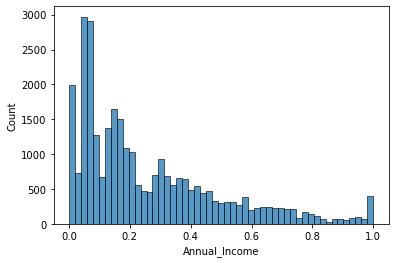

In [39]:
plot_dens=sns.histplot(df['Annual_Income'])

Monthly Balance

In [40]:
#Wal roboczo
df.Monthly_Balance.describe()

count    30000.000000
mean       401.999364
std        212.378825
min          0.366147
25%        271.397208
50%        336.355022
75%        467.496147
max       1576.288935
Name: Monthly_Balance, dtype: float64

Wal: Zgadzamy się. 

In [41]:
df.Monthly_Balance = pd.DataFrame(mmscaler.fit_transform(pd.DataFrame(df.Monthly_Balance)),columns=['Monthly_Balance'])

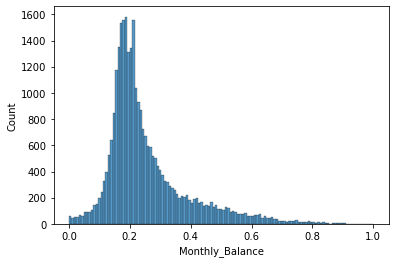

In [42]:
plot_dens=sns.histplot(df['Monthly_Balance'])

Amount_invested_monthly

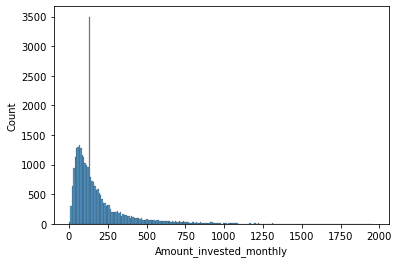

In [43]:
plot_dens=sns.histplot(df['Amount_invested_monthly'])

Wal: Zgoda.

In [44]:
#Tylko górne
upper_lim = df.Amount_invested_monthly.quantile(.99)
df.Amount_invested_monthly = np.where(df.Amount_invested_monthly > upper_lim, upper_lim, df.Amount_invested_monthly)
df.Amount_invested_monthly = np.log1p(df.Amount_invested_monthly)

df = df.reset_index(drop=True)

In [45]:
df.Amount_invested_monthly = pd.DataFrame(mmscaler.fit_transform(pd.DataFrame(df.Amount_invested_monthly)),columns=['Amount_invested_monthly'])

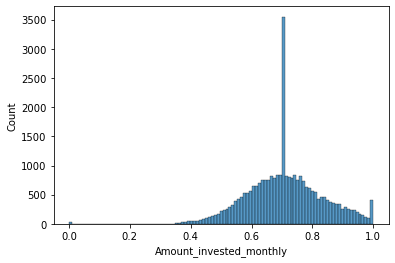

In [46]:
plot_dens=sns.histplot(df['Amount_invested_monthly'])

Total_EMI_per_month

In [47]:
df.Total_EMI_per_month.describe()

count    30000.000000
mean      1353.021999
std       8148.046052
min          0.000000
25%         30.473538
50%         69.219446
75%        158.709886
max      82236.000000
Name: Total_EMI_per_month, dtype: float64

Wal: Zgadzamy się.

In [48]:
#Ponownie tylko górne
upper_lim = df.Total_EMI_per_month.quantile(.96)
df.Total_EMI_per_month = np.where(df.Total_EMI_per_month > upper_lim, upper_lim, df.Total_EMI_per_month)
df = df.reset_index(drop=True)

df.Total_EMI_per_month = np.log1p(df.Total_EMI_per_month)

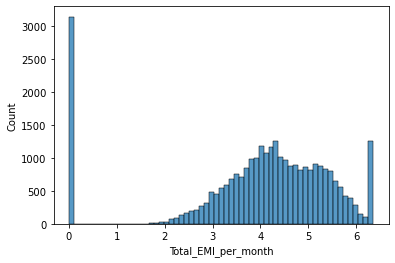

In [49]:
plot_dens=sns.histplot(df['Total_EMI_per_month'])

Credit_Utilization_Ratio

Wal: Zgadzamy się.

In [50]:
df.Credit_Utilization_Ratio = pd.DataFrame(mmscaler.fit_transform(pd.DataFrame(df.Credit_Utilization_Ratio)),columns=['Credit_Utilization_Ratio'])

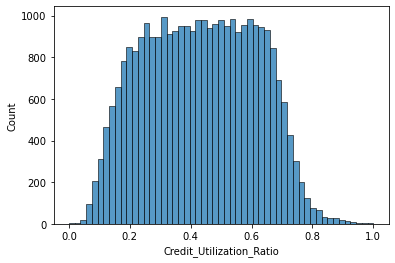

In [51]:
plot_dens=sns.histplot(df['Credit_Utilization_Ratio'])

Outstanding_Debt 

Wal: Zgadzamy się.

In [52]:
df.Outstanding_Debt = pd.DataFrame(mmscaler.fit_transform(pd.DataFrame(df.Outstanding_Debt)),columns=['Outstanding_Debt'])

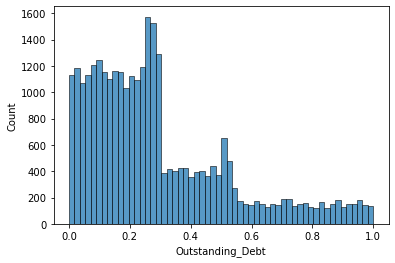

In [53]:
plot_dens=sns.histplot(df['Outstanding_Debt'])

Num_Credit_Inquiries

In [54]:
df.Num_Credit_Inquiries.describe()

count    30000.000000
mean        27.081933
std        191.391600
min          0.000000
25%          3.000000
50%          6.000000
75%          9.000000
max       2589.000000
Name: Num_Credit_Inquiries, dtype: float64

Wal: Zgadzamy się.

In [55]:
upper_lim = df.Num_Credit_Inquiries.quantile(.96)
df.Num_Credit_Inquiries = np.where(df.Num_Credit_Inquiries > upper_lim, upper_lim, df.Num_Credit_Inquiries)

df = df.reset_index(drop=True)

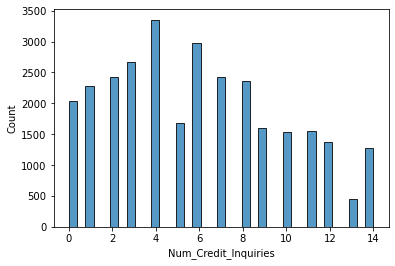

In [56]:
plot_dens=sns.histplot(df['Num_Credit_Inquiries'])

Changed_Credit_Limit

Wal: Zgadzamy się.

In [57]:
df.Changed_Credit_Limit = pd.DataFrame(mmscaler.fit_transform(pd.DataFrame(df.Changed_Credit_Limit)),columns=['Changed_Credit_Limit'])

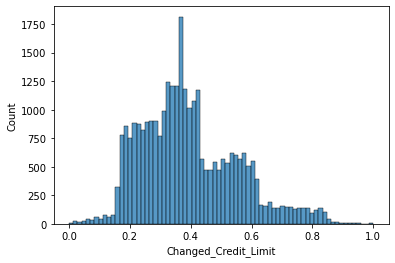

In [58]:
plot_dens=sns.histplot(df['Changed_Credit_Limit'])

Age

In [59]:
df.Age.describe()

count    30000.00000
mean       116.65780
std        687.14236
min         14.00000
25%         25.00000
50%         33.00000
75%         42.00000
max       8666.00000
Name: Age, dtype: float64

In [60]:
df[df.Age==14].shape

(328, 34)

Wal: Zgadzamy się.

In [61]:
upper_lim = df.Age.quantile(.98)
df.Age = np.where(df.Age > upper_lim, upper_lim, df.Age)
df = df.reset_index(drop=True)


df.Age = pd.DataFrame(mmscaler.fit_transform(pd.DataFrame(df.Age)),columns=['Age'])

<AxesSubplot:xlabel='Age', ylabel='Count'>

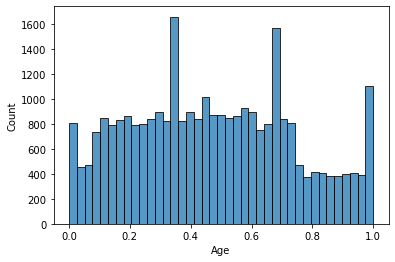

In [62]:
sns.histplot(df.Age)

In [63]:
factor=3

Monthly_Inhand_Salary

<AxesSubplot:xlabel='Monthly_Inhand_Salary', ylabel='Count'>

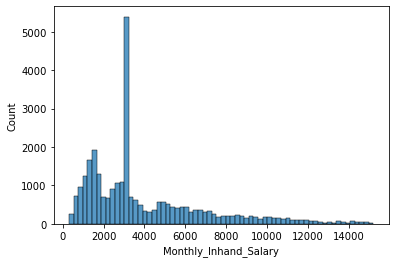

In [64]:
sns.histplot(df.Monthly_Inhand_Salary)

Num_Bank_Accounts

In [65]:
df.Num_Bank_Accounts.describe()

count    30000.000000
mean        16.326533
std        114.031595
min          0.000000
25%          4.000000
50%          6.000000
75%          7.000000
max       1798.000000
Name: Num_Bank_Accounts, dtype: float64

Wal: Zgadzamy się.

<AxesSubplot:xlabel='Num_Bank_Accounts', ylabel='Count'>

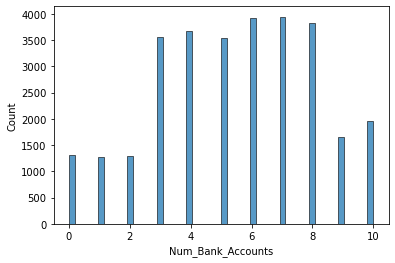

In [66]:
upper_lim = df.Num_Bank_Accounts.quantile(.98)
lower_lim = df.Num_Bank_Accounts.quantile(.00)
df.Num_Bank_Accounts = np.where(df.Num_Bank_Accounts > upper_lim, upper_lim, df.Num_Bank_Accounts)
df.Num_Bank_Accounts = np.where(df.Num_Bank_Accounts < lower_lim, lower_lim, df.Num_Bank_Accounts)
df = df.reset_index(drop=True)

sns.histplot(df.Num_Bank_Accounts)

Num_Credit_Card

In [67]:
df.Num_Credit_Card.describe()

count    30000.000000
mean        22.649500
std        130.927613
min          0.000000
25%          4.000000
50%          5.000000
75%          7.000000
max       1497.000000
Name: Num_Credit_Card, dtype: float64

Wal: Zgadzamy się.

<AxesSubplot:xlabel='Num_Credit_Card', ylabel='Count'>

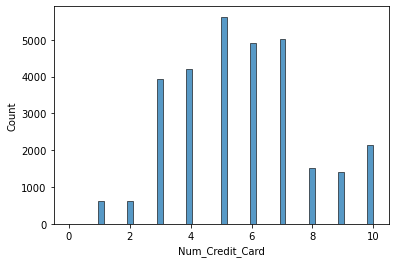

In [68]:
upper_lim = df.Num_Credit_Card.quantile(.97)
lower_lim = df.Num_Credit_Card.quantile(.00)
df.Num_Credit_Card = np.where(df.Num_Credit_Card > upper_lim, upper_lim, df.Num_Credit_Card)
df.Num_Credit_Card = np.where(df.Num_Credit_Card < lower_lim, lower_lim, df.Num_Credit_Card)

df = df.reset_index(drop=True)

sns.histplot(df.Num_Credit_Card)

Interest_Rate

In [69]:
df.Interest_Rate.describe()

count    30000.000000
mean        70.239600
std        455.250534
min          1.000000
25%          8.000000
50%         14.000000
75%         20.000000
max       5776.000000
Name: Interest_Rate, dtype: float64

Wal: Zgadzamy się. W naszym przypadku wystarczy wziąć kwantyl 98.

<AxesSubplot:xlabel='Interest_Rate', ylabel='Count'>

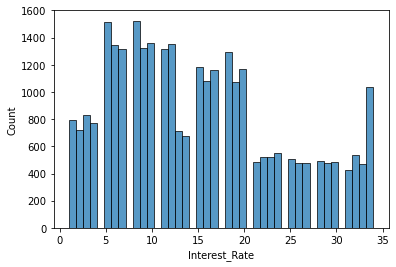

In [70]:
#upper_lim = df.Interest_Rate.quantile(.97)
upper_lim = df.Interest_Rate.quantile(.98)
df.Interest_Rate = np.where(df.Interest_Rate > upper_lim, upper_lim, df.Interest_Rate)
df = df.reset_index(drop=True)

sns.histplot(df.Interest_Rate)

Num_of_Loan

In [71]:
df.Num_of_Loan.describe()

count    30000.000000
mean         7.773433
std         65.718342
min          0.000000
25%          2.000000
50%          3.000000
75%          5.000000
max       1496.000000
Name: Num_of_Loan, dtype: float64

Wal: Zgadzamy się.

<AxesSubplot:xlabel='Num_of_Loan', ylabel='Count'>

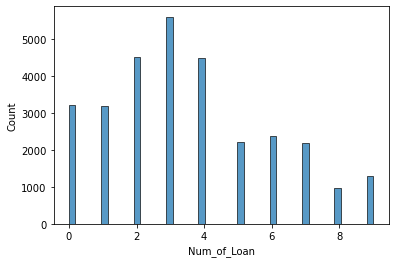

In [72]:
upper_lim = df.Num_of_Loan.quantile(.99)
#print(upper_lim)
df.Num_of_Loan = np.where(df.Num_of_Loan > upper_lim, upper_lim, df.Num_of_Loan)
df = df.reset_index(drop=True)

sns.histplot(df.Num_of_Loan)

Delay_from_due_date

In [73]:
df.Delay_from_due_date.describe()

count    30000.000000
mean        21.176367
std         14.913956
min         -5.000000
25%         10.000000
50%         18.000000
75%         28.000000
max         67.000000
Name: Delay_from_due_date, dtype: float64

Wal: Zgadzamy się.

<AxesSubplot:xlabel='Delay_from_due_date', ylabel='Count'>

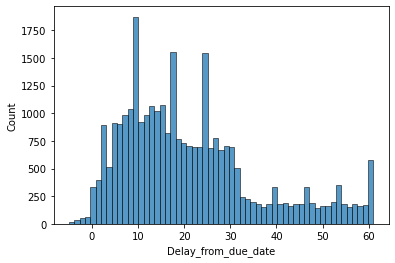

In [74]:
upper_lim = df.Delay_from_due_date.quantile(.99)
df.Delay_from_due_date = np.where(df.Delay_from_due_date > upper_lim, upper_lim, df.Delay_from_due_date)
df = df.reset_index(drop=True)
sns.histplot(df.Delay_from_due_date)

Num_of_Delayed_Payment

In [75]:
df.Num_of_Delayed_Payment.describe()

count    30000.000000
mean        29.197167
std        213.085025
min         -3.000000
25%          9.000000
50%         14.000000
75%         18.000000
max       4397.000000
Name: Num_of_Delayed_Payment, dtype: float64

In [76]:
dftest = df.copy()

Wal: Zgadzamy się. Wartości ujemne są błędne. Można je także usunąć we wcześniejszym etapie.

<AxesSubplot:xlabel='Num_of_Delayed_Payment', ylabel='Count'>

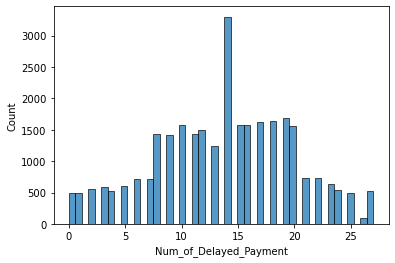

In [77]:
upper_lim = df.Num_of_Delayed_Payment.quantile(.99)
lower_lim = df.Num_of_Delayed_Payment.quantile(.01)
df.Num_of_Delayed_Payment = np.where(df.Num_of_Delayed_Payment > upper_lim, upper_lim, df.Num_of_Delayed_Payment)
df.Num_of_Delayed_Payment = np.where(df.Num_of_Delayed_Payment < lower_lim, upper_lim, df.Num_of_Delayed_Payment)
sns.histplot(df.Num_of_Delayed_Payment)

<AxesSubplot:xlabel='Num_of_Delayed_Payment', ylabel='Count'>

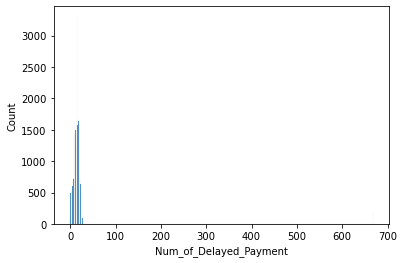

In [78]:
#Na pozór normalny, zobaczmy jednak jak nieefektywny byłby alternatywny sposób
upper_lim = dftest['Num_of_Delayed_Payment'].mean () + dftest['Num_of_Delayed_Payment'].std () * factor
lower_lim = dftest['Num_of_Delayed_Payment'].mean () - dftest['Num_of_Delayed_Payment'].std () * factor
dftest['Num_of_Delayed_Payment'] = np.where(dftest['Num_of_Delayed_Payment'] < upper_lim, dftest['Num_of_Delayed_Payment'], upper_lim)
dftest['Num_of_Delayed_Payment'] = np.where(dftest['Num_of_Delayed_Payment'] > lower_lim, dftest['Num_of_Delayed_Payment'], lower_lim)
sns.histplot(dftest.Num_of_Delayed_Payment)

Wal: Widzimy, że też rozważaliście usunięcie typów pożyczek. Tak jak wcześniej wpomnieliśmy, wydaje się, że kluczowa jest róźnorodność portfela, której informacje kryją się w kolumnie 'Credit Mix'.

In [79]:
#df.drop(columns=['Personal Loan','Student Loan','Payday Loan','Not Specified','Mortgage Loan', 'Home Equity Loan','Debt Consolidation Loan', 'Credit-Builder Loan', 'Auto Loan' ], inplace=True)

## Redukcja liczby zmiennych

In [80]:
df.info()
df.iloc[:, 10:30]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 34 columns):
 #   Column                    Non-Null Count  Dtype           
---  ------                    --------------  -----           
 0   Month                     30000 non-null  int64           
 1   Age                       30000 non-null  float64         
 2   Occupation                30000 non-null  object          
 3   Annual_Income             30000 non-null  float64         
 4   Monthly_Inhand_Salary     30000 non-null  float64         
 5   Num_Bank_Accounts         30000 non-null  float64         
 6   Num_Credit_Card           30000 non-null  float64         
 7   Interest_Rate             30000 non-null  float64         
 8   Num_of_Loan               30000 non-null  float64         
 9   Delay_from_due_date       30000 non-null  float64         
 10  Num_of_Delayed_Payment    30000 non-null  float64         
 11  Changed_Credit_Limit      30000 non-null  float64     

,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Monthly_Balance,spent,payment_value,Auto Loan,Credit-Builder Loan,Debt Consolidation Loan,Home Equity Loan,Mortgage Loan,Not Specified,Payday Loan,Personal Loan
0,6.0,0.401731,0.0,0.293737,0.319150,284.0,0,0.000000,0.582320,0.351898,1,2.0,0,0,0,0,0,0,0,0
1,17.0,0.663547,9.0,0.953740,0.699412,219.0,1,4.128725,0.694667,0.150990,0,0.0,0,0,0,0,1,1,0,1
2,0.0,0.240290,14.0,0.239067,0.051073,191.0,0,5.324402,1.000000,0.213201,0,0.0,0,0,1,0,1,0,0,0
3,13.0,0.394244,11.0,0.509094,0.436420,232.0,1,3.335997,0.612852,0.227719,0,0.0,0,1,0,1,0,0,0,0
4,0.0,0.378802,4.0,0.161826,0.688554,249.0,0,5.230026,0.691508,0.442302,1,1.0,1,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,12.0,0.185774,4.0,0.148700,0.170561,319.0,0,0.000000,0.714421,0.327073,1,1.0,0,0,0,0,0,0,0,0
29996,15.0,0.585166,4.0,0.286914,0.272603,70.0,1,4.454857,0.764309,0.151493,1,0.0,0,0,0,1,0,1,0,1
29997,23.0,0.370613,6.0,0.741006,0.290478,142.0,1,3.397263,0.500139,0.176697,0,2.0,0,0,0,0,1,0,0,1
29998,16.0,0.259242,9.0,0.576617,0.083114,25.0,1,4.233756,0.599092,0.186840,0,0.0,0,1,1,0,1,0,0,1


Wal: Nie zgadzamy się, zastąpiliśmy przecież wcześniej 'payment_value' modą. Nie ma nulli.

In [81]:
#dużo nanów to się pozbędziemy
# nie wykonujemy df.drop(columns=['payment_value'], inplace = True)

<AxesSubplot:>

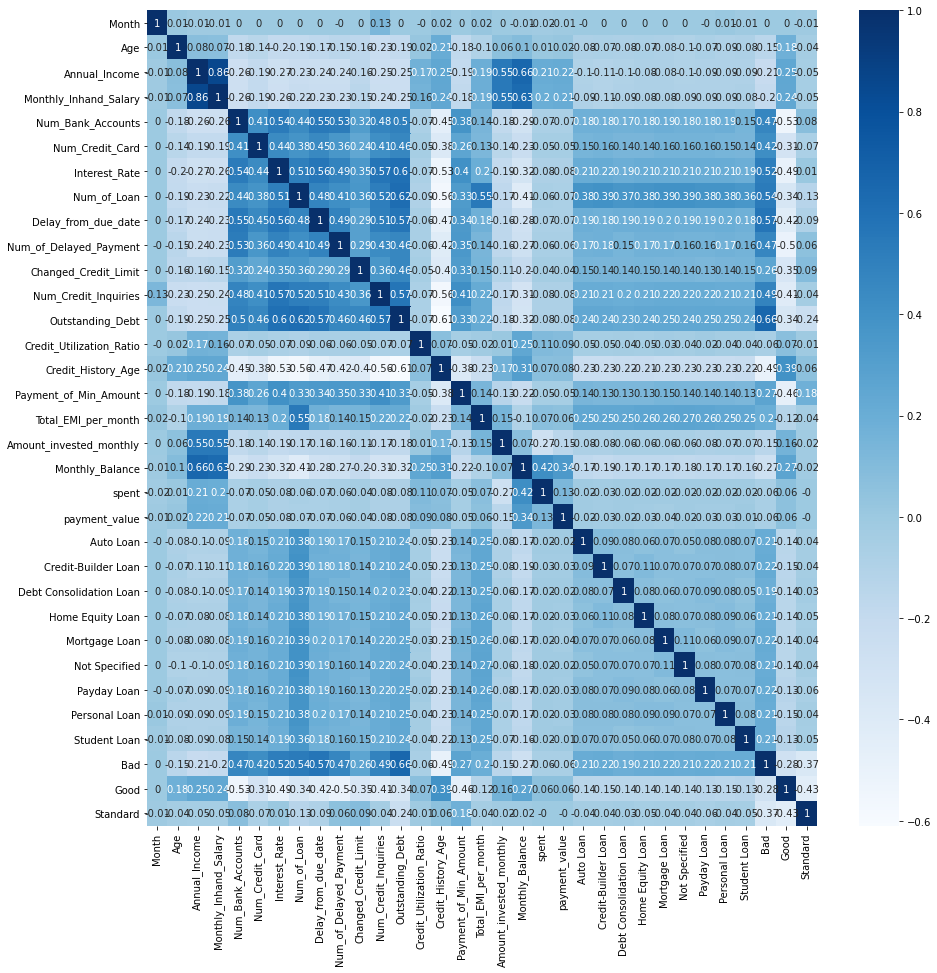

In [82]:
fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(df.corr().round(2), cmap="Blues", annot=True)

In [83]:
df.columns

Index(['Month', 'Age', 'Occupation', 'Annual_Income', 'Monthly_Inhand_Salary',
       'Num_Bank_Accounts', 'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan',
       'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit',
       'Num_Credit_Inquiries', 'Outstanding_Debt', 'Credit_Utilization_Ratio',
       'Credit_History_Age', 'Payment_of_Min_Amount', 'Total_EMI_per_month',
       'Amount_invested_monthly', 'Monthly_Balance', 'spent', 'payment_value',
       'Auto Loan', 'Credit-Builder Loan', 'Debt Consolidation Loan',
       'Home Equity Loan', 'Mortgage Loan', 'Not Specified', 'Payday Loan',
       'Personal Loan', 'Student Loan', 'Bad', 'Good', 'Standard'],
      dtype='object')

Wal: Początkowo zastaniwaliśmy się czy nie usunąć kolumny 'Month', być może decyzje polityczne np. uchwała budżetu, która zazwyczaj ma miejsce na początku roku klandarzowego mogą wpływać na sytuację finansową w państwie (wysokość stopy procentowej, a co za tym idzie skłonność do konsumpcji). Jednak w zbiorze danych mamy tylko 4 unikalne miesiące od września do grudnia i rzeczywiście ta zmienna nie wydaje się wpływać na rating kredytowy w tym wypadku.

In [84]:
#zawód i miesiąc są równomiernie rozłożone i nie wykazywały wpływu na rating kredytowy
df = df.drop(columns=['Occupation','Month'])
df.drop(columns=['Personal Loan','Student Loan','Payday Loan','Not Specified','Mortgage Loan', 'Home Equity Loan','Debt Consolidation Loan', 
'Credit-Builder Loan', 'Auto Loan' ], inplace=True)

Wal: Jendak usunęliście rodzaje pożyczek, tak jak my też chcieliśmy zrobić. Według nas dobra decyzja.

In [85]:
#annual income i monthly salary bardzo skorelowane

In [86]:
df.Monthly_Inhand_Salary.corr(df_target)

0.01987856574635302

In [87]:
df.Annual_Income.corr(df_target)

0.016971148892045564

Wal: My również usuwamy zmienną 'Annual_Income'.

In [88]:
df = df.drop(columns=['Annual_Income'])

<AxesSubplot:>

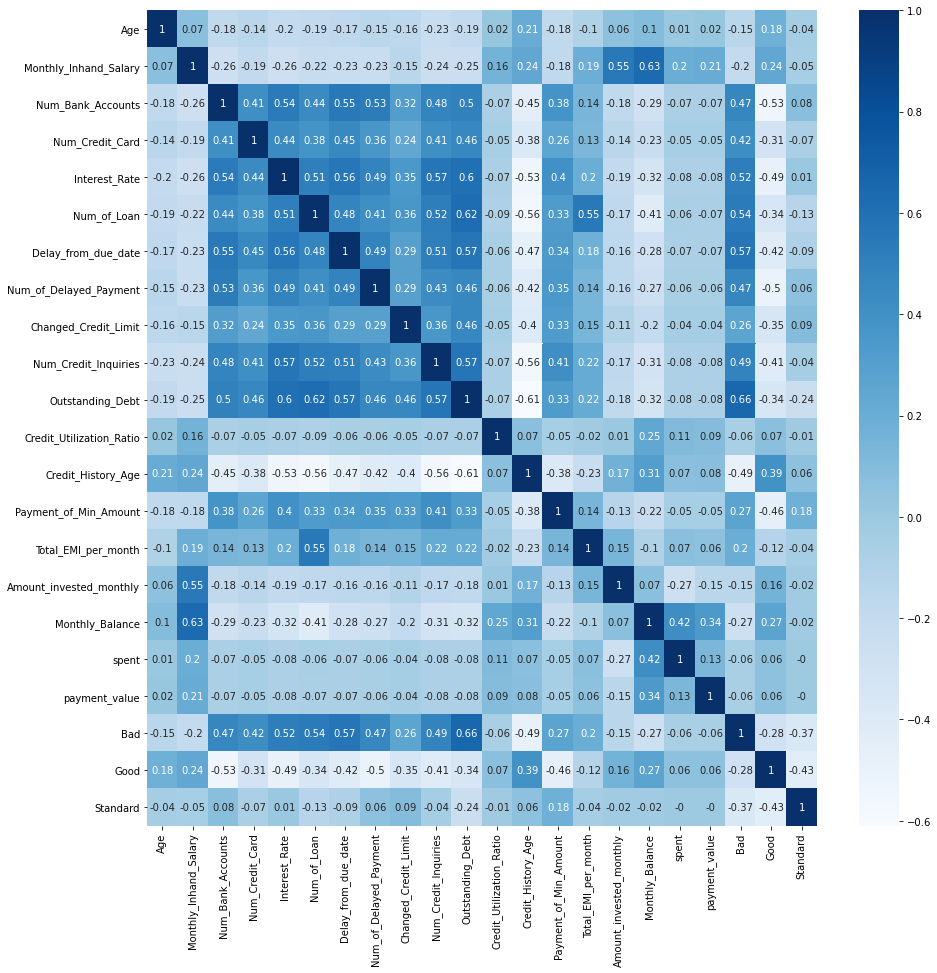

In [89]:
fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(df.corr().round(2), cmap="Blues", annot=True)

Wal: Obserwując korelacje poszczególonych zmiennych, również wydaje nam się, że nie ma konieczności wprowadzać więcej zmian.

In [864]:
df.info()
#ready :))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Month                     30000 non-null  int64  
 1   Age                       30000 non-null  float64
 2   Monthly_Inhand_Salary     30000 non-null  float64
 3   Num_Bank_Accounts         30000 non-null  float64
 4   Num_Credit_Card           30000 non-null  float64
 5   Interest_Rate             30000 non-null  float64
 6   Num_of_Loan               30000 non-null  float64
 7   Delay_from_due_date       30000 non-null  float64
 8   Num_of_Delayed_Payment    30000 non-null  float64
 9   Changed_Credit_Limit      30000 non-null  float64
 10  Num_Credit_Inquiries      30000 non-null  float64
 11  Outstanding_Debt          30000 non-null  float64
 12  Credit_Utilization_Ratio  30000 non-null  float64
 13  Credit_History_Age        30000 non-null  float64
 14  Paymen